# Import packages

In [1]:
import ast
import math
import numpy as np
import altair as alt
import pandas as pd
import shapely as shp
import geopandas as gpd
from datetime import timedelta, time
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.widgets import Button, Slider, CheckButtons

import itertools
from dijkstar import Graph, find_path

from helper_functions import open_processed_gtfs, open_delays, open_stations

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

# Notebook settings

In [2]:
DELAYS_FILEPATH = r'Intermediates\\delays_assigned.csv'
LINKS_FILEPATH = r'Intermediates\\GTFS_20190914\\gtfs_links_corrected.geojson'
STATIONS_FILEPATH = r'Intermediates\\GTFS_20190914\\gtfs_stations_corrected.geojson'
RESULTS_FILEPATH = r'First model results\\D05 to D06.csv'
# RESULTS_ABOVE_ZERO_FILEPATH = r'First model results\\D05 to D06 above zero.csv'


distribution = stats.exponnorm
# distribution_above_zero = stats.halflogistic

# Load data

In [3]:
gtfs_stations = open_stations(STATIONS_FILEPATH)
gtfs_stations.head(5)

,stop_id,stop_name,connections,geometry
0,E02,SHAW METRO STATION,"[[E03, E01], [E01, E03]]",POINT (1306094.353 454461.868)
1,D11,CHEVERLY METRO STATION,"[[D10, D12], [D12, D10]]",POINT (1336488.46 455202.936)
2,G02,CAPITOL HEIGHTS METRO STATION,"[[G01, G03], [G03, G01]]",POINT (1337007.377 445376.966)
3,E03,U STREET METRO STATION,"[[E04, E02], [E02, E04]]",POINT (1304034.044 455361.654)
4,D12,LANDOVER METRO STATION,"[[D11, D13], [D13, D11]]",POINT (1343622.123 461562.939)


In [4]:
delays = open_delays(DELAYS_FILEPATH)

# Assign dates to delays
delays['date'] = [date.date() for date in delays['sched_arrival_time']]

delays.head(3)

Amount of delay values: 3_802_649


,line_name,trip_id,shape_id,stop,sched_arrival_time,previous_stop,next_stop,real_arrival_time,delay,timestep,date
0,BLUE,3121350_18154_2019-09-14,46,G05,2019-09-14 06:54:00,NaN,G04,2019-09-14 06:46:04,-476.0,6.0,2019-09-14
1,BLUE,3121350_18154_2019-09-14,46,G04,2019-09-14 06:57:00,G05,G03,2019-09-14 06:56:12,-48.0,6.0,2019-09-14
2,GREEN,3120258_18154_2019-09-14,117,F11,2019-09-14 07:00:00,NaN,F10,2019-09-14 06:45:42,-858.0,7.0,2019-09-14


In [5]:
results = pd.read_csv(RESULTS_FILEPATH, converters={"connection": eval, "other_connection": eval, 'dist_params': eval})
results.head(5)

,connection,delay_range,timestep,other_connection,future_timestep,dist_params
0,"(D05, D06)",0.0,5.0,"(A01/C01, A02)",5.0,"[1.9363084332005704, -44.1373622808718, 35.677..."
1,"(D05, D06)",0.0,5.0,"(A01/C01, A02)",6.0,"[0.8006572486325675, -32.32943211393756, 53.75..."
2,"(D05, D06)",0.0,5.0,"(A01/C01, A02)",7.0,"[0.6121180864618025, -33.56552270335543, 53.07..."
3,"(D05, D06)",0.0,5.0,"(A01/C01, A02)",8.0,"[1.6210548244218175, -62.26000703681639, 45.26..."
4,"(D05, D06)",0.0,5.0,"(A01/C01, A02)",9.0,"[1.0275163967240994, -62.8695570847448, 50.827..."


# Single connection

In [6]:
# Settings
current_connection = ('D05', 'D06')
delay_range = 0
other_connection = ('D06', 'D07')

In [7]:
# Find all ocurrences of current connection delays within delay range
ocurrences = delays[(delays['stop'] == current_connection[0]) & \
                    (delays['next_stop'] == current_connection[1]) & \
                    (delays['delay'] >= delay_range * 60) & \
                    (delays['delay'] < (delay_range + 1) * 60)].copy()
print(len(ocurrences))
ocurrences.head(5)


4242


,line_name,trip_id,shape_id,stop,sched_arrival_time,previous_stop,next_stop,real_arrival_time,delay,timestep,date
889,SILVER,3120915_18154_2019-09-14,330,D05,2019-09-14 08:01:00,D04,D06,2019-09-14 08:01:47,47.0,8.0,2019-09-14
1744,BLUE,3121260_18154_2019-09-14,88,D05,2019-09-14 08:33:00,D04,D06,2019-09-14 08:33:34,34.0,8.0,2019-09-14
2901,ORANGE,3120505_18154_2019-09-14,258,D05,2019-09-14 09:17:00,D04,D06,2019-09-14 09:17:31,31.0,9.0,2019-09-14
3100,SILVER,3120950_18154_2019-09-14,330,D05,2019-09-14 09:25:00,D04,D06,2019-09-14 09:25:20,20.0,9.0,2019-09-14
4324,SILVER,3120826_18154_2019-09-14,330,D05,2019-09-14 10:13:00,D04,D06,2019-09-14 10:13:54,54.0,10.0,2019-09-14


In [8]:
# Find all delay values at other connection at same date and timestep pairs
date_timestep_pairs = {}
for _, row in ocurrences.iterrows():
    if (row['date'], row['timestep']) not in date_timestep_pairs:
        date_timestep_pairs[(row['date'], row['timestep'])] = 1
    else:
        date_timestep_pairs[(row['date'], row['timestep'])] += 1


possible_matches = delays[(delays['stop'] == other_connection[0]) & \
                          (delays['next_stop'] == other_connection[1])]
df_list = []
for date_timestep_pair, count in date_timestep_pairs.items():
    matching_delays = possible_matches[(possible_matches['date'] == date_timestep_pair[0]) & \
                                        (possible_matches['timestep'] == date_timestep_pair[1])]

    for _ in range(count):
        df_list.append(matching_delays)
matching_values = pd.concat(df_list)

# Above zero results so filter out lower values
# matching_values = matching_values[matching_values['delay'] > 0]

print(f"Amount of matching values: {len(matching_values):_}")
matching_values.head(5)

Amount of matching values: 71_401


,line_name,trip_id,shape_id,stop,sched_arrival_time,previous_stop,next_stop,real_arrival_time,delay,timestep,date
960,SILVER,3120915_18154_2019-09-14,330,D06,2019-09-14 08:03:00,D05,D07,2019-09-14 08:03:46,46.0,8.0,2019-09-14
1066,ORANGE,3120365_18154_2019-09-14,258,D06,2019-09-14 08:07:00,D05,D07,2019-09-14 08:05:35,-85.0,8.0,2019-09-14
1156,BLUE,3121246_18154_2019-09-14,88,D06,2019-09-14 08:11:00,D05,D07,2019-09-14 08:09:10,-110.0,8.0,2019-09-14
1263,SILVER,3120954_18154_2019-09-14,330,D06,2019-09-14 08:15:00,D05,D07,2019-09-14 08:14:27,-33.0,8.0,2019-09-14
1384,ORANGE,3120448_18154_2019-09-14,258,D06,2019-09-14 08:19:00,D05,D07,2019-09-14 08:17:32,-88.0,8.0,2019-09-14


In [9]:
# Create temporal distribution of data
high_bound = (50 + 95 / 2) / 100
low_bound = (50 - 95 / 2) / 100

matching_values['data_timestep'] = [pd.Timestamp(arrival_time).hour + pd.Timestamp(arrival_time).minute / 60 for arrival_time in matching_values['sched_arrival_time'].values]
data_times, data_means, data_highs, data_lows = [], [], [], []
for timestep in np.arange(5, 24, (1 / 60)):  # 10 minute intervals
    values = matching_values[(matching_values['data_timestep'] >= timestep-0.5) & (matching_values['data_timestep'] < timestep + 0.5)]['delay'].values
    values = np.array(values)
    values.sort()

    values = values[~np.isnan(values)]

    if len(values) > 4:
        try:
            dist_params = distribution.fit(values)
        except:
            print(values)
            raise ValueError

        data_means.append(distribution.mean(*dist_params))
        data_highs.append(distribution.ppf(high_bound, *dist_params))
        data_lows.append(distribution.ppf(low_bound, *dist_params))
        data_times.append(timestep)

In [10]:
# Create temporal distribution of results
test = results[(results['connection'] == current_connection) & \
                (results['other_connection'] == other_connection) & \
                (results['delay_range'] == delay_range) & \
                (results['timestep'] == results['future_timestep'])]

result_times, result_means, result_highs, result_lows = [], [], [], []
for _, row in test.iterrows():
    dist_params = row['dist_params']

    result_times.append(row['timestep'])
    result_means.append(distribution.mean(*dist_params))
    result_lows.append(distribution.ppf(0.025, *dist_params))
    result_highs.append(distribution.ppf(0.975, *dist_params))

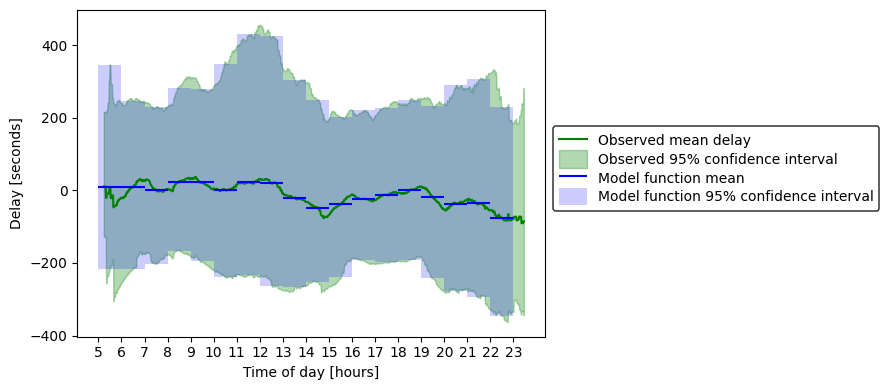

In [11]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(9, 4))

# Plot data range
plt.plot(data_times, data_means, 'g', label='Observed mean delay')
plt.fill_between(x=data_times, y1=data_lows, y2=data_highs, color='g', alpha=0.3, label='Observed 95% confidence interval')

# Plot result range
for time, mean, low, high in zip(result_times, result_means, result_lows, result_highs):
    if time == result_times[0]:
        plt.hlines(mean, time, time+1, 'b', label='Model function mean')
        plt.fill_between(x=[time, time+1], y1=[low, low], y2=[high, high], color='b', alpha=0.2, linewidth=0, label='Model function 95% confidence interval')
    else:
        plt.hlines(mean, time, time+1, 'b')
        plt.fill_between(x=[time, time+1], y1=[low, low], y2=[high, high], color='b', alpha=0.2, linewidth=0)

# plt.title(f"Confidence interval for delays at {other_connection[0]} in the direction of {other_connection[1]} \n given a {delay_range}-{delay_range+1} minute delay at {current_connection[0]} in the direction of {current_connection[1]}")
plt.xlabel('Time of day [hours]')
plt.ylabel('Delay [seconds]')
legend = plt.legend(bbox_to_anchor=(1.003, 0.665),  ncol=1,handleheight=1.6, labelspacing=0.05)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.1)

plt.xticks(np.arange(5, 24, 1))
# plt.grid(axis='y')
plt.tight_layout()
fig.savefig(r'C:\Users\lange\OneDrive\Documenten\Jaar_6-Msc_CE_TTE\Thesis\Codebase\Codebase figures\first_model_confidence_test.png', dpi=300)

# Against related

In [18]:
# Settings
current_connection = ('D05', 'D06')
delay_range = 4
other_connection = ('D06', 'D07')

In [19]:
delays_sorted = delays.sort_values(by=['trip_id', 'sched_arrival_time']).copy()

stop_values = delays_sorted['stop'].values
delay_values = delays_sorted['delay'].values
trip_ids = delays_sorted['trip_id'].values

related_forward = pd.DataFrame({'line': delays_sorted['line_name'].values,
                                'stop': stop_values,
                                'next_stop': [*stop_values[1:], stop_values[-1]],
                                'delay': delay_values,
                                'delay_at_next': [*delay_values[1:], delay_values[-1]],
                                'sched_arrival_time': delays_sorted['sched_arrival_time'].values,
                                'timestep': delays_sorted['timestep'].values,
                                'date': delays_sorted['date'].values,
                                'trip_id': trip_ids,
                                'prev_trip_id': [trip_ids[-1], *trip_ids[:-1]],
                                'next_trip_id': [*trip_ids[1:], trip_ids[0]]})

related_forward = related_forward[(related_forward['trip_id'] == related_forward['prev_trip_id']) | (related_forward['trip_id'] == related_forward['next_trip_id'])]
related_forward.loc[related_forward['trip_id'] != related_forward['next_trip_id'], ['next_stop', 'delay_at_next']] = None
related_forward = related_forward.drop(columns=['trip_id', 'next_trip_id', 'prev_trip_id'])
print(f"Total: {len(related_forward):_}")

related_forward = related_forward[(pd.notna(related_forward['delay'])) & (pd.notna(related_forward['delay_at_next']))]
print(f"Filtered to only viable: {len(related_forward):_}")

related_forward.head(3)

Total: 3_802_596
Filtered to only viable: 3_648_725


,line,stop,next_stop,delay,delay_at_next,sched_arrival_time,timestep,date
0,SILVER,G05,G04,-569.0,-88.0,2019-10-14 13:08:00,13.0,2019-10-14
1,SILVER,G04,G03,-88.0,-106.0,2019-10-14 13:11:00,13.0,2019-10-14
2,SILVER,G03,G02,-106.0,-110.0,2019-10-14 13:14:00,13.0,2019-10-14


In [20]:
# Find all ocurrences of current connection delays within delay range
ocurrences = related_forward[(related_forward['stop'] == current_connection[0]) & \
                            (related_forward['next_stop'] == current_connection[1]) & \
                            (related_forward['delay'] >= delay_range * 60) & \
                            (related_forward['delay'] < (delay_range + 1) * 60)].copy()
print(len(ocurrences))
ocurrences.head(5)

658


,line,stop,next_stop,delay,delay_at_next,sched_arrival_time,timestep,date
8607,BLUE,D05,D06,292.0,284.0,2019-10-14 12:45:00,12.0,2019-10-14
36961,BLUE,D05,D06,246.0,239.0,2019-09-22 12:59:00,12.0,2019-09-22
36988,BLUE,D05,D06,282.0,263.0,2019-09-22 15:14:00,15.0,2019-09-22
37366,BLUE,D05,D06,242.0,225.0,2019-09-22 17:29:00,17.0,2019-09-22
38263,SILVER,D05,D06,286.0,271.0,2019-09-22 08:50:00,8.0,2019-09-22


In [21]:
# Create temporal distribution of data
high_bound = (50 + 95 / 2) / 100
low_bound = (50 - 95 / 2) / 100

ocurrences['data_timestep'] = [pd.Timestamp(arrival_time).hour + pd.Timestamp(arrival_time).minute / 60 for arrival_time in ocurrences['sched_arrival_time'].values]
data_times, data_means, data_highs, data_lows = [], [], [], []
for timestep in np.arange(5, 24, (1 / 60)):  # 10 minute intervals
    values = ocurrences[(ocurrences['data_timestep'] >= timestep-0.5) & (ocurrences['data_timestep'] < timestep + 0.5)]['delay_at_next'].values
    values = np.array(values)
    values.sort()

    values = values[~np.isnan(values)]

    if len(values) > 4:
        try:
            dist_params = distribution.fit(values)
        except:
            print(values)
            raise ValueError

        data_means.append(distribution.mean(*dist_params))
        data_highs.append(distribution.ppf(high_bound, *dist_params))
        data_lows.append(distribution.ppf(low_bound, *dist_params))
        data_times.append(timestep)

In [22]:
# Create temporal distribution of results
test = results[(results['connection'] == current_connection) & \
                (results['other_connection'] == other_connection) & \
                (results['delay_range'] == delay_range) & \
                (results['timestep'] == results['future_timestep'])]

result_times, result_means, result_highs, result_lows = [], [], [], []
for _, row in test.iterrows():
    dist_params = row['dist_params']

    result_times.append(row['timestep'])
    result_means.append(distribution.mean(*dist_params))
    result_lows.append(distribution.ppf(0.025, *dist_params))
    result_highs.append(distribution.ppf(0.975, *dist_params))

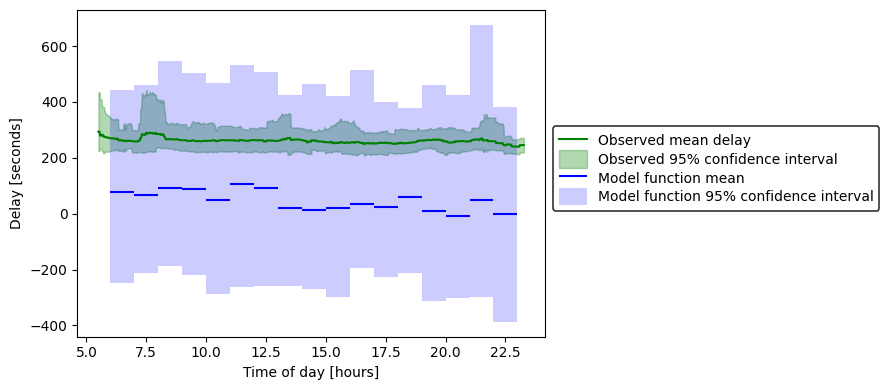

In [23]:
fig = plt.figure(figsize=(9, 4))

# Plot data range
plt.plot(data_times, data_means, 'g', label='Observed mean delay')
plt.fill_between(x=data_times, y1=data_lows, y2=data_highs, color='g', alpha=0.3, label='Observed 95% confidence interval')

# Plot result range
for time, mean, low, high in zip(result_times, result_means, result_lows, result_highs):
    if time == result_times[0]:
        plt.hlines(mean, time, time+1, 'b', label='Model function mean')
        plt.fill_between(x=[time, time+1], y1=[low, low], y2=[high, high], color='b', alpha=0.2, linewidth=0, label='Model function 95% confidence interval')
    else:
        plt.hlines(mean, time, time+1, 'b')
        plt.fill_between(x=[time, time+1], y1=[low, low], y2=[high, high], color='b', alpha=0.2, linewidth=0)

# plt.title(f"Confidence interval for delays at {other_connection[0]} in the direction of {other_connection[1]} \n given a {delay_range}-{delay_range+1} minute delay at {current_connection[0]} in the direction of {current_connection[1]}")
plt.xlabel('Time of day [hours]')
plt.ylabel('Delay [seconds]')
# plt.legend()

legend = plt.legend(bbox_to_anchor=(1.003, 0.665),  ncol=1,handleheight=1.6, labelspacing=0.05)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.2)

plt.tight_layout()
fig.savefig(f"Codebase figures\\first_model_confidence_related_range_{delay_range}.png", dpi=300)